In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import itertools as itr
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTEN

In [7]:
data=pd.read_csv('data.csv')


C:\Users\Moustapha\AppData\Local\Temp\ipykernel_23528\2127919575.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('data.csv')


In [5]:
data.shape

(1496, 688)

In [167]:
columns=[]
for column in data:
    num_na=data[column].isna().sum()
    if(num_na>0):
        print(f'{column}: NA\'s={num_na}')
        columns.append(column)

cellularity: NA's=40
er_status_measured_by_ihc: NA's=23
neoplasm_histologic_grade: NA's=52
primary_tumor_laterality: NA's=76
mutation_count: NA's=31
3-gene_classifier_subtype: NA's=166
tumor_size: NA's=12
tumor_stage: NA's=395
death_from_cancer: NA's=1


In [ ]:
columns=[column for column in data if data[column].dtype!='object' and data[column].unique()[0]!=0 and data[column].unique()[1]!=1 ]
for column in columns:
    plt.figure() 
    data[column].hist()
    plt.xlabel(column)
    plt.title(f'Histogram of {column}')
    plt.show()  

#remove row where death_from_cancer=null


In [ ]:
plt.figure()
data['cancer_type'].hist()
plt.xlabel('cancer_type')
plt.show()

In [ ]:
for column in data.select_dtypes(include=['object']).columns:
    category_counts = data[column].value_counts()
    
    print(f"\nColumn: {column}")
    print(category_counts)

In [4]:
X=data.drop('cancer_type',axis=1)
y=data['cancer_type']

In [8]:
def get_class_indices(series):
    return series.groupby(series).apply(lambda x: x.index.tolist())

#class_indices = get_class_indices(data['cancer_type'])


In [8]:

X_train, X_validate_test, y_train, y_validate_test = train_test_split(X_train_selected, y_train_selected, test_size=0.3, stratify=y_train_selected, random_state=42)
X_validate, X_test, y_validate, y_test =train_test_split(X_validate_test,y_validate_test,test_size=0.5,random_state=42)

In [9]:
cat_columns=['pr_status',  'pam50_+_claudin-low_subtype', 'primary_tumor_laterality',   'inferred_menopausal_state',   'her2_status',   'er_status',   'er_status_measured_by_ihc',   '3-gene_classifier_subtype', 'death_from_cancer']

def drop_single_class_columns(df):
  unique_value_counts = df.nunique()
  single_value_columns = unique_value_counts[unique_value_counts == 1].index
  return df.drop(columns=single_value_columns)


def remove_infrequent_categories(data, threshold=0.05):

  filtered_data = data.copy()
  categorical_columns = filtered_data.select_dtypes(include='object').columns
  categorical_columns = [column for column in categorical_columns if column.endswith('_mut')]


  for column in categorical_columns:
      filtered_data=filtered_data.loc[filtered_data[column].isin(filtered_data[column].value_counts().index[filtered_data[column].value_counts()/len(filtered_data) > threshold])]

  return filtered_data

def one_hot_encode_columns(df, columns,isTrain, encoder):

  enc=OneHotEncoder(sparse_output=False)
  encoded_data=enc.fit_transform(df[columns])
  # if(isTrain==True):
  #   encoded_data = encoder.fit_transform(df[columns])
  # else:
  #    encoded_data=encoder.transform(df[columns])

  encoded_df = pd.DataFrame(encoded_data, columns=enc.get_feature_names_out(columns))


  
  df_encoded = pd.concat([df.reset_index(drop=True),encoded_df.reset_index(drop=True)],axis=1)

  return  df_encoded.drop(columns,axis=1)

def data_preprocess(df,encoder,isTrain):
  
  
  
  df = df.drop('patient_id', axis=1)
  df=df.drop('cohort',axis=1)
  
  
  numerical_columns = ['neoplasm_histologic_grade', 'mutation_count', 'tumor_size', 'tumor_stage']
  df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

  categorical_columns = ['er_status_measured_by_ihc', 'primary_tumor_laterality', '3-gene_classifier_subtype', 'death_from_cancer']
  for column in categorical_columns:
    most_frequent_class = df[column].mode()[0]
    df[column] = df[column].fillna(most_frequent_class)

  # label encoding for cellularity 40 nan values transformed to 0
  mapping = {
      'Low': 1,
      'Moderate': 2,
      'High': 3,
  }
#['pr_status',   'primary_tumor_laterality',   'inferred_menopausal_state',   'her2_status',   'er_status',   'er_status_measured_by_ihc',   '3-gene_classifier_subtype', 'death_from_cancer']

  df['cellularity'] = df['cellularity'].str.strip()
  df["cellularity"] = df["cellularity"].map(mapping)
  df["cellularity"] = df["cellularity"].fillna(3)


  her2_mapping={
  'LOSS' : -1,
  'NEUTRAL' : 0,
  'GAIN' : 1,
  }

  df=df[df.her2_status_measured_by_snp6 != 'UNDEF']
  df['her2_status_measured_by_snp6'] = df['her2_status_measured_by_snp6'].str.strip()
  df['her2_status_measured_by_snp6'] = df['her2_status_measured_by_snp6'].map(her2_mapping)

  label_encoders = {}
  df=drop_single_class_columns(df)
  #df=remove_infrequent_categories(df,threshold=0.001)

  y = df["cancer_type"]
  df = df.drop('cancer_type', axis = 1) 
  label_encoder = LabelEncoder()
  y  = label_encoder.fit_transform(y)
  y = pd.Series(y)

  df=one_hot_encode_columns(df,cat_columns,encoder=encoder,isTrain=isTrain)
  

  
  for column in df.columns:
      if df[column].dtype == 'object' and column not in ['pr_status',  'pam50_+_claudin-low_subtype', 'primary_tumor_laterality',   'inferred_menopausal_state',   'her2_status',   'er_status',   'er_status_measured_by_ihc',   '3-gene_classifier_subtype', 'death_from_cancer']:
          
          le = LabelEncoder()

          df[column] = le.fit_transform(df[column].astype(str))

          label_encoders[column] = le
  
  last_seven = df.iloc[:, -7:]
  part_before = df.iloc[:, :2] 
  part_after = df.iloc[:, 2:]
  df = pd.concat([part_before, last_seven, part_after], axis=1)
  df = df.iloc[:, :-7]


  
  return df,y

In [38]:
X, y=data_preprocess(data,'','')



In [7]:
y.value_counts()

0    1197
3     165
1     114
2      18
Name: count, dtype: int64

In [39]:
class_indices=get_class_indices(y)


In [40]:
desired_samples = {0: 600, 1: 100, 2: 12, 3: 150}


all_indices = np.arange(len(X))


X_train_selected = pd.DataFrame()
y_train_selected = []

X_test_selected=pd.DataFrame()
y_test_selected=[]

selected=[]

for class_label, num_samples in desired_samples.items():
    
  indices = class_indices[class_label]
  
  selected_indices = np.random.choice(indices, size=num_samples, replace=False)
  
  selected.extend(selected_indices.tolist())
  
  X_train_selected = pd.concat([X_train_selected, X.loc[selected_indices]])
  y_train_selected.extend(y[selected_indices])


print(len(all_indices))
print(len(selected))

test_indices = np.setdiff1d(all_indices, sorted(selected))

print(len(test_indices))

X_test_selected = pd.concat([X_test_selected,X.loc[test_indices]])
y_test_selected.extend(y[test_indices])

y_train_selected = pd.Series(y_train_selected)
y_test_selected=pd.Series(y_test_selected)

1494
862
632


In [41]:
X_train=X_train_selected
y_train=y_train_selected

In [42]:
X_validate, X_test, y_validate, y_test =train_test_split(X_test_selected,y_test_selected,test_size=0.5,random_state=42)

In [10]:
y_validate.value_counts()

0    250
3      9
2      4
1      3
Name: count, dtype: int64

In [11]:
def create_df(X,y):
    return pd.concat([X.reset_index(drop=True),pd.Series(data=y.reset_index(drop=True),name='cancer_type')],axis=1)

In [ ]:
encoder=OneHotEncoder(sparse_output=False)
X_train, y_train=data_preprocess(create_df(X_train,y_train),encoder,isTrain=True)
X_validate, y_validate = data_preprocess(create_df(X_validate,y_validate),encoder,isTrain=False)
X_test, y_test=data_preprocess(create_df(X_test,y_test),encoder=encoder,isTrain=False)



In [13]:
train=create_df(X_train,y_train)
validate=create_df(X_validate,y_validate)
test=create_df(X_test,y_test)
train,validate=train.align(validate,join='inner',axis=1)
train,test=train.align(test,join='inner',axis=1)

In [14]:
X_train=train.drop('cancer_type',axis=1)
X_validate=validate.drop('cancer_type',axis=1)
X_test=test.drop('cancer_type',axis=1)
y_train=train['cancer_type']
y_validate=validate['cancer_type']
y_test=test['cancer_type']

In [43]:
from sklearn.utils import resample
import imblearn
# X_minority_1=X_y_trian[X_y_trian.iloc[:,702]==2]
# X_minority_2=X_y_trian[X_y_trian.iloc[:,702]==1]
# X_minority_3=X_y_trian[X_y_trian.iloc[:,702]==3]
# data_minority_resample_1=resample(X_minority_1,replace=True,n_samples=800)
# data_minority_resample_2=resample(X_minority_2,replace=True,n_samples=800)
# data_minority_resample_3=resample(X_minority_3,replace=True,n_samples=800)
# X_y_trian=pd.concat([data_minority_resample_1,data_minority_resample_2,data_minority_resample_3,X_y_trian])

ROS=imblearn.over_sampling.RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled=ROS.fit_resample(X_train,y_train)

In [44]:
X_train=X_train_resampled
y_train=y_train_resampled

In [42]:
total_samples = len(y_train)
class_counts = y_train.value_counts()
class_weights = total_samples / (len(class_counts) * class_counts)
print(class_weights)

0     0.381
3     1.270
1     1.905
2    15.875
Name: count, dtype: float64


In [45]:


#sample_weights = y_train.map(class_weights)

dtrain=xgb.DMatrix(X_train, label=y_train)


In [46]:
#class_counts = y_validate.value_counts()
#total_samples = len(y_validate)
#class_weights = total_samples / (len(class_counts) * class_counts)

#sample_weights = y_validate.map(class_weights)
dval=xgb.DMatrix(X_validate,label=y_validate)

In [49]:

params={
	'objective':'multi:softmax',
    'eval_metric':'mlogloss',
	'num_class':4,
	'tree_method':'hist',
	'device':'cuda',
}
num_boost_round=100
model=xgb.train(params, dtrain, num_boost_round=num_boost_round)

predictions=model.predict(dval)



print("Accuracy Score:", accuracy_score(y_validate,predictions))


Accuracy Score: 0.8987341772151899


In [48]:

report = classification_report(y_validate, predictions, labels=[0, 1, 2, 3])

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       301
           1       0.27      0.80      0.40         5
           2       0.00      0.00      0.00         3
           3       0.09      0.14      0.11         7

    accuracy                           0.90       316
   macro avg       0.33      0.47      0.36       316
weighted avg       0.93      0.90      0.91       316



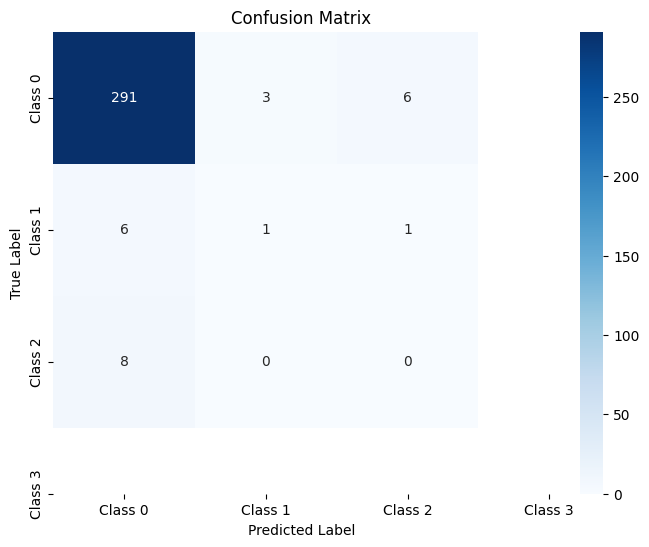

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_validate, predictions)

class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import joblib

#to use the model with high acc
loaded_model=joblib.load('xgboost.pkl')

**HyperParameter Tuning**

In [62]:
import cupy as cp
hyper_params={
    'objective':['multi:softmax'],
    'eval_metric':['logloss','mse','mae'],
	'eta':[0.01,0.1,0.3,0.9],
	'gamma':[0.05,0.1,0.2],
	'max_depth':[3,6,12],
	'n_estimators':[100,200,300],
    'num_parallel_tree':[3,10,30],
	'subsample':[0.3,0.5,0.8],
	'sampling_method':['uniform','gradient_based'],
	'lambda':[0.1, 0.5 , 1, 5, 7,10],
    'alpha':[0.01,0.05,0.1,0.3,1],
	'tree_method':['hist','approx'],
	'grow_policy':['depthwise','lossguide'],
}
allParams=sorted(hyper_params)

combinations=list(itr.product(*(hyper_params[param] for param in allParams)))


def grid_search_xgb(parameters, X_train, y_train, cv=5):
  """
  Performs grid search with KFold cross-validation for XGBoost with DMatrix.

  Args:
      params: Dictionary of hyperparameter grids to search over.
      x_train: DMatrix containing training data features.
      y_train: Training data target labels.
      cv: Number of folds for KFold cross-validation (default=5).
      scoring: Evaluation metric for scoring models (default='neg_mean_squared_error').
      eval_metric: Evaluation metric reported during training (default='rmse').

  Returns:
      best_params: Dictionary containing the best hyperparameters found.
      best_model: The XGBoost model with the best hyperparameters.
      cv_results: Dictionary containing cross-validation results for each parameter combination.
  """

  best_params = None
  f1_scores=[float('-inf'),float('-inf'),float('-inf')]

  cv_results = {}


  kfold = KFold(n_splits=cv, shuffle=True)

  for combination in parameters:
    for train_idx, val_idx in kfold.split(X_train, y_train):
      x_train_fold = X_train.iloc[train_idx]
      x_val_fold = X_train.iloc[val_idx]
      y_train_fold = y_train[train_idx]
      y_val_fold = y_train[val_idx]


      train_dmatrix = xgb.DMatrix(x_train_fold, label=y_train_fold)
      val_dmatrix = xgb.DMatrix(x_val_fold, label=y_val_fold)

      params = {
          'num_class': 4,
          'alpha': combination[0],
          'device': 'cuda',
          'eta': combination[1],
          'eval_metric': 'logloss',
          'gamma': combination[3],
          'grow_policy': combination[4],
          'lambda': combination[5],
          'max_depth': combination[6],
          'num_parallel_tree': combination[8],
          'objective': 'multi:softmax',
          'sampling_method': combination[10],
          'subsample': combination[11],
          'tree_method': combination[12],
      }


      model = xgb.train(params, train_dmatrix,
                  num_boost_round=200)

      #eval_results = model.eval(val_dmatrix, name='validation')
      #validation_score = eval_results['validation']['logloss']

      predictions=model.predict(val_dmatrix)
      report=classification_report(y_val_fold,predictions,output_dict=True)
      print(f'{report} for parameters {params}')
      flags=[False,False,False]
      for key, value in report.items():
        if key==1 and f1_scores[key]<value:
          f1_scores[key]=value
          flags[key-1]=True
        elif key==2 and f1_scores[key]<value:
          f1_scores[key]=value
          flags[key-1]=True
        elif key==3 and f1_scores[key]<value:
          f1_scores[key]=value
          flags[key-1]=value

      if flags[0]==True or flags[1]==True or flags[2]==True:
        best_scores = f1_scores
        best_params = combination
        best_model = model

      if combination not in cv_results:
        cv_results[combination] = []
      cv_results[combination].append(f1_scores)

  return best_params, best_model, cv_results


best_params, best_model, cv_results = grid_search_xgb(combinations, X_train, y_train)

# Access results
print(f"Best Hyperparameters: {best_params}")
print(f"Best Model Score: {cv_results}")

{'0': {'precision': 0.975, 'recall': 0.8731343283582089, 'f1-score': 0.9212598425196851, 'support': 134.0}, '1': {'precision': 0.9655172413793104, 'recall': 0.9790209790209791, 'f1-score': 0.9722222222222222, 'support': 143.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 140.0}, '3': {'precision': 0.9225806451612903, 'recall': 1.0, 'f1-score': 0.959731543624161, 'support': 143.0}, 'accuracy': 0.9642857142857143, 'macro avg': {'precision': 0.9657744716351502, 'recall': 0.963038826844797, 'f1-score': 0.9633034020915171, 'support': 560.0}, 'weighted avg': {'precision': 0.965442853170189, 'recall': 0.9642857142857143, 'f1-score': 0.9637825132386975, 'support': 560.0}} for parameters {'num_class': 4, 'alpha': 0.01, 'device': 'cuda', 'eta': 0.01, 'eval_metric': 'logloss', 'gamma': 0.05, 'grow_policy': 'depthwise', 'lambda': 0.1, 'max_depth': 3, 'num_parallel_tree': 3, 'objective': 'multi:softmax', 'sampling_method': 'uniform', 'subsample': 0.3, 'tree_method': 'hist'}
{

KeyboardInterrupt: 